<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/DNN_photoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use neural network algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.



# Load some libraries

In [1]:
pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 6.9 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

# Doanload the dataset

In [3]:
from astroquery.sdss import SDSS

# look for availabe tables and columns in
# http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx

query = " SELECT TOP 200000 objID, ra ,dec, z, zerr, class, \
        cModelMag_r as mag_r, cModelMag_g as mag_g, cModelMag_i as mag_i, \
        cModelMag_u as mag_u, cModelMag_z as mag_z \
        FROM  SpecPhotoAll  WHERE (class = 'GALAXY') \
        AND z>0.1 AND z<1. AND ra>200 AND ra<230 AND dec>10 AND dec<40"


d = SDSS.query_sql(query)

/usr/local/lib/python3.10/dist-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


# Clean the data

In [4]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
print (d.keys())

['objID', 'ra', 'dec', 'z', 'zerr', 'class', 'mag_r', 'mag_g', 'mag_i', 'mag_u', 'mag_z']


# for photo-z work
# The target/label values are spectroscopic redshifts

In [6]:
# we will use just dereddend magnitudes
mags = ['mag_g', 'mag_r', 'mag_i','mag_z','mag_u']
d=d[d[mags[0]]==d[mags[0]]]
d=d[d[mags[1]]==d[mags[1]]]
d=d[d[mags[2]]==d[mags[2]]]
d=d[d[mags[3]]==d[mags[3]]]
d=d[d[mags[4]]==d[mags[4]]]

def f(x):
    return float(x)
f2 = np.vectorize(f)

#and color combinations created from them.
cols= []
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])

# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

cnt = len(mags)
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        inputs[:, cnt] = np.array(f2(d[mags[i]])) - np.array(f2(d[mags[j]]))
        cnt += 1


In [7]:
targets = np.array(f2(d['z']))

# we will split the data into a trainind and testing sample.


In [8]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

print("Training inputs: ",x_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",x_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (121325, 19)
Training outputs:  (121325,)
Testing inputs:  (30332, 19)
Testing outputs:  (30332,)


# Import Tensorflow

In [9]:
import tensorflow as tf

In [48]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(19,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

In [49]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                1280      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,505
Trainable params: 5,505
Non-trainable params: 0
_________________________________________________________________


In [50]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=64,shuffle=True)

Epoch 1/10
1517/1517 [==============================] - 6s 3ms/step - loss: 0.0222 - val_loss: 0.0076
Epoch 2/10
1517/1517 [==============================] - 5s 3ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 3/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 4/10
1517/1517 [==============================] - 5s 3ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 5/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 6/10
1517/1517 [==============================] - 5s 3ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 7/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 8/10
1517/1517 [==============================] - 5s 3ms/step - loss: 0.0056 - val_loss: 0.0080
Epoch 9/10
1517/1517 [==============================] - 5s 3ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 10/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.005

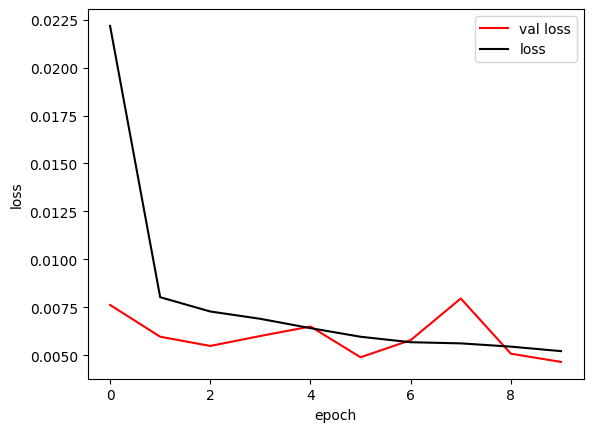

In [51]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

948/948 [==============================] - 1s 1ms/step


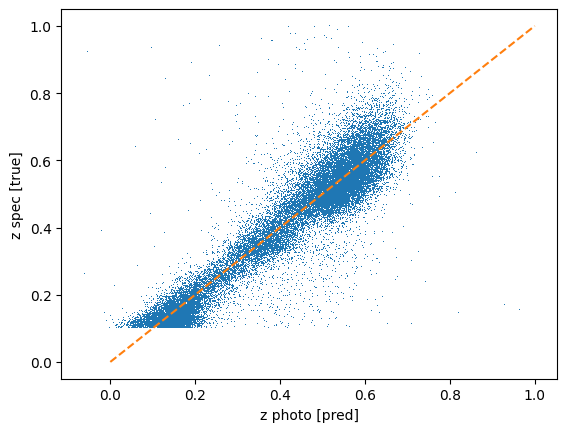

In [52]:
pred=model.predict(x_test).squeeze()
pred
plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()

(0.3, 0.65)

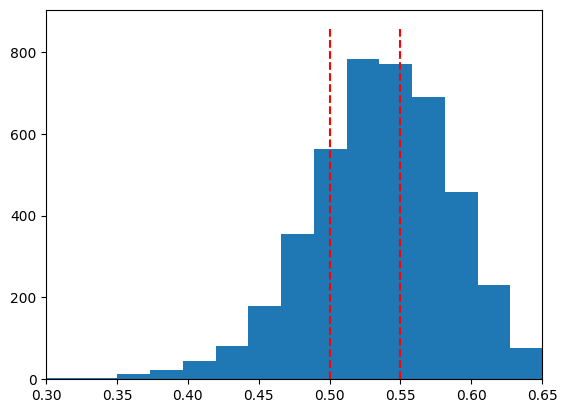

In [53]:
specz=[0.5,0.55]
a=plt.hist(pred[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')
plt.xlim((0.3,0.65))

In [60]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(19,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
model.build()

In [61]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=64,shuffle=True)

Epoch 1/10
1517/1517 [==============================] - 8s 4ms/step - loss: 0.0816 - val_loss: 0.0558
Epoch 2/10
1517/1517 [==============================] - 9s 6ms/step - loss: 0.0528 - val_loss: 0.0473
Epoch 3/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0495 - val_loss: 0.0579
Epoch 4/10
1517/1517 [==============================] - 8s 5ms/step - loss: 0.0486 - val_loss: 0.0449
Epoch 5/10
1517/1517 [==============================] - 8s 5ms/step - loss: 0.0481 - val_loss: 0.0453
Epoch 6/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0470 - val_loss: 0.0444
Epoch 7/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0465 - val_loss: 0.0449
Epoch 8/10
1517/1517 [==============================] - 8s 5ms/step - loss: 0.0460 - val_loss: 0.0442
Epoch 9/10
1517/1517 [==============================] - 7s 4ms/step - loss: 0.0454 - val_loss: 0.0570
Epoch 10/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.045

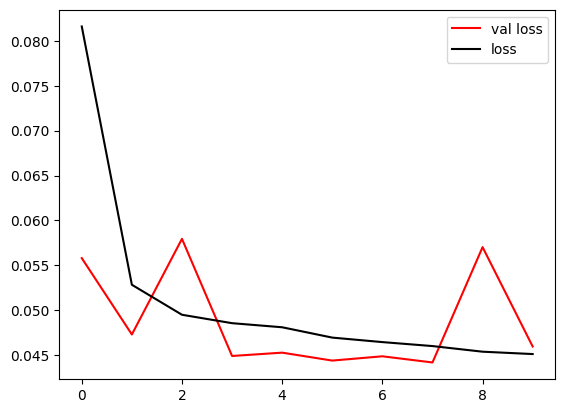

In [62]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.legend()

948/948 [==============================] - 2s 2ms/step


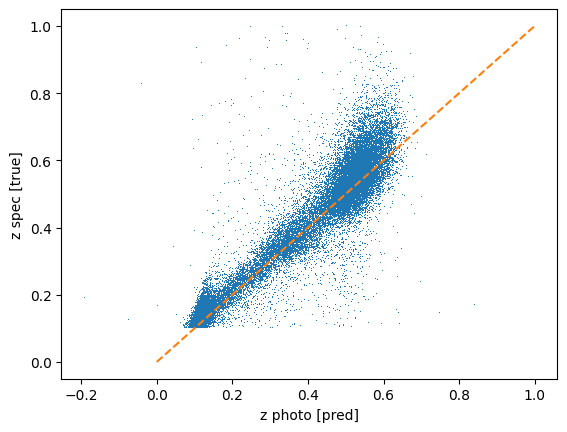

In [63]:
pred=model.predict(x_test).squeeze()
plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()


(0.3, 0.65)

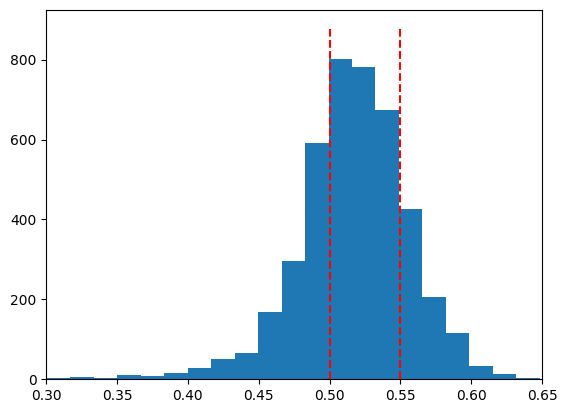

In [64]:
specz=[0.5,0.55]
a=plt.hist(pred[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')
plt.xlim((0.3,0.65))